In [185]:

# Import necessary libraries
#remove .legacy if not M1 mac
import numpy as np
from keras.initializers import GlorotUniform
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers.legacy import SGD #MAC M1 compatible with legacy
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Optimizer #MAC M1 compatible with legacy
import keras.backend as K
from keras.optimizers.legacy import Adagrad #MAC M1 compatible with legacy
from keras.optimizers.legacy import RMSprop #MAC M1 compatible with legacy
from keras.optimizers.legacy import Adam #MAC M1 compatible with legacy
from keras.utils import to_categorical
from keras.optimizers.legacy import Nadam

In [186]:
# Load data from CSV file
tdata=pd.read_csv("team13/task2/train_data.csv",header=None)
train_data=tdata.values
tlabels=pd.read_csv("team13/task2/train_label.csv",header=None)
train_labels=tlabels.values
tedata=pd.read_csv("team13/task2/test_data.csv",header=None)
test_data=tedata.values
telabels=pd.read_csv("team13/task2/test_label.csv",header=None)
test_labels=telabels.values
vdata=pd.read_csv("team13/task2/val_data.csv",header=None)
val_data=vdata.values
vlabels=pd.read_csv("team13/task2/val_label.csv",header=None)
val_labels=vlabels.values
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


(2000, 36)
(500, 36)
(500, 36)


In [187]:
# Define parameters
input_size = train_data.shape[1]
num_classes = tlabels.iloc[:, 0].nunique()
learning_rate = 0.01
num_epochs = 200
#Number of batches is 10 so batch size =200 # not working
batch_size = 32
stopping_threshold = 0.001
train_labels=to_categorical(train_labels, num_classes)
test_labels=to_categorical(test_labels, num_classes)
val_labels=to_categorical(val_labels, num_classes)
print("Input size: ", input_size)
print("Number of classes: ", num_classes)
print(tdata.head())
# #for same initial weights
seed = 18
np.random.seed(seed)
tf.random.set_seed(seed)

Input size:  36
Number of classes:  5
         0         1         2         3         4         5         6    
0  0.232240  0.207808  0.071658  0.070243  0.157873  0.144533  0.099580  \
1  0.087019  0.205943  0.135941  0.111470  0.240927  0.244776  0.044332   
2  0.173857  0.239948  0.239948  0.109094  0.058365  0.035727  0.017606   
3  0.150840  0.000000  0.076907  0.060331  0.221430  0.108376  0.086752   
4  0.042944  0.011484  0.027623  0.215481  0.255972  0.255972  0.085409   

         7         8         9   ...        26        27        28        29   
0  0.112758  0.131904  0.141752  ...  0.170039  0.232240  0.203068  0.232240  \
1  0.072265  0.037744  0.031663  ...  0.051223  0.062553  0.244776  0.244776   
2  0.031597  0.007561  0.121138  ...  0.239948  0.181729  0.239948  0.239948   
3  0.073696  0.028351  0.098406  ...  0.112638  0.034365  0.102482  0.241761   
4  0.017368  0.049767  0.255972  ...  0.042157  0.170107  0.244938  0.255972   

         30        31        3

In [188]:

# Define MLFFNN model with 2 hidden layers and tanh activation function
def build_model(normalization_method):
    model = Sequential()
    
    # Input layer
    model.add(Dense(64, input_dim=input_size, activation='tanh', kernel_initializer=GlorotUniform(seed=seed)))
    
    # Hidden layers
    if normalization_method == 'batch_norm':
        model.add(BatchNormalization())

    model.add(Dense(32, activation='tanh', kernel_initializer=GlorotUniform(seed=seed+1)))
    
    if normalization_method == 'batch_norm':
        model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform(seed=seed+2)))
    
    return model

In [189]:
def accuracy_from_confusion_matrix(confusion_matrix):
  diagonal_sum = np.trace(confusion_matrix)
  total_sum = np.sum(confusion_matrix)
  accuracy = diagonal_sum / total_sum
  return accuracy

In [190]:
# Train the model
def train_model(model, train_data, train_labels, test_data, test_labels, num_epochs, batch_size, stopping_threshold):
    
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=stopping_threshold, patience=8,mode='auto', restore_best_weights=True)
    history = model.fit(train_data, train_labels, verbose=0, epochs=200, batch_size = batch_size, validation_data=(val_data, val_labels),callbacks=[early_stopping])

    # Plot average error on training and test data vs. epoch
    plt.plot(history.history['loss'], label='Training Error')
    plt.plot(history.history['val_loss'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Average Error vs. Epoch')
    plt.legend()
    plt.show()

    # Generate predictions on training and test data
    train_predictions = model.predict(train_data)
    test_predictions = model.predict(test_data)

    # Calculate confusion matrices for training and test data
    train_confusion_matrix = confusion_matrix(np.argmax(train_labels, axis=1), np.argmax(train_predictions, axis=1))
    test_confusion_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(test_predictions, axis=1))

    # return train_confusion_matrix, test_confusion_matrix, convergence_epoch
    return train_confusion_matrix, test_confusion_matrix, np.argmin(history.history['val_loss'])

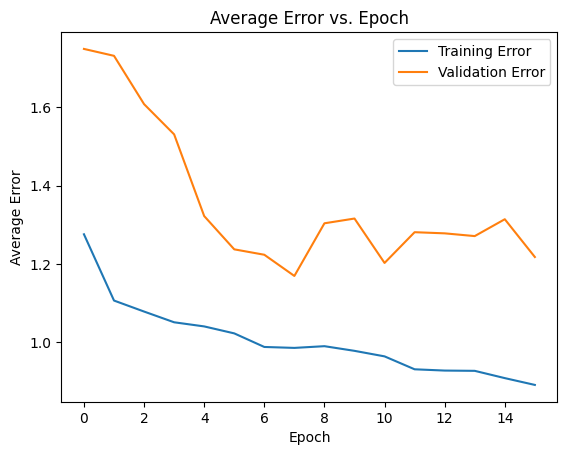

16/16 [==============================] - 0s 2ms/step
[[249  22  35  44  50]
 [ 26 213  42  74  45]
 [ 33  10 215  26 116]
 [ 14  23  24 307  32]
 [ 15  14  95  22 254]]
[[54  5 10 20 11]
 [ 6 44  9 16 25]
 [ 7  3 42  6 42]
 [ 6  7  8 74  5]
 [10  9 29  6 46]]
Train Accuracy: 0.619
Test Accuracy: 0.52
Convergence Epoch: 7


In [191]:
# Build and compile the model with batch normalization
model_batch_norm = build_model(normalization_method='batch_norm')
init_weights = model_batch_norm.get_weights()
model_batch_norm.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with batch normalization
train_confusion_matrix_batch_norm, test_confusion_matrix_batch_norm, convergence_epoch_batch_norm = train_model(model_batch_norm, train_data, train_labels, test_data, test_labels, num_epochs, batch_size, stopping_threshold)

print(train_confusion_matrix_batch_norm)
print(test_confusion_matrix_batch_norm)
# Calculate accuracy for training data
train_accuracy = accuracy_from_confusion_matrix(train_confusion_matrix_batch_norm)
print("Train Accuracy:", train_accuracy)
# Calculate accuracy for test data
test_accuracy = accuracy_from_confusion_matrix(test_confusion_matrix_batch_norm)
print("Test Accuracy:", test_accuracy)
print("Convergence Epoch:", convergence_epoch_batch_norm)


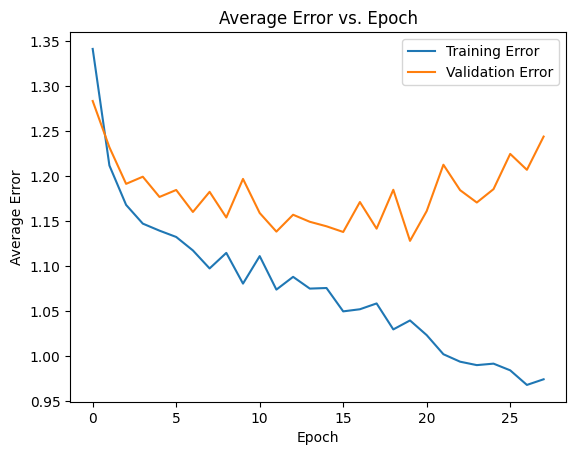

16/16 [==============================] - 0s 472us/step
[[266  41  49  23  21]
 [ 26 256  60  36  22]
 [ 28  20 294  18  40]
 [ 34  50  31 270  15]
 [ 17  31 174  18 160]]
[[64 12 11  8  5]
 [ 4 48 25  9 14]
 [11  4 63  6 16]
 [11  9  9 71  0]
 [ 8  9 50  8 25]]
Train Accuracy: 0.623
Test Accuracy: 0.542
Convergence Epoch: 19


In [192]:
# Build and compile the model with no normalization
model_no_norm = build_model(normalization_method=None)
model_no_norm.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with no normalization
train_confusion_matrix_no_norm, test_confusion_matrix_no_norm, convergence_epoch_no_norm = train_model(model_no_norm, train_data, train_labels, test_data, test_labels, num_epochs, batch_size, stopping_threshold)

print(train_confusion_matrix_no_norm)
print(test_confusion_matrix_no_norm)
# Calculate accuracy for training data
train_accuracy = accuracy_from_confusion_matrix(train_confusion_matrix_no_norm)
print("Train Accuracy:", train_accuracy)
# Calculate accuracy for test data
test_accuracy = accuracy_from_confusion_matrix(test_confusion_matrix_no_norm)
print("Test Accuracy:", test_accuracy)
print("Convergence Epoch:", convergence_epoch_no_norm)

